# Decision Tree for Regression
## Instructions
In this problem we want to implement Decision Trees for regression from scratch **without** using the *scikit-learn* library. Implement the generation of a full tree of given depth. There is no need to implement tree pruning. Check your implementation with the proposed functions $ f(x) $, $ g(x) $, and $ h(x_1, x_2) $. Plot the approximations and consider train/test errors depending on different tree depths. 

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from utils.metrics import MSE
from utils.tree import RegressionTree

In [2]:
### Settings
np.random.seed(0)
pd.set_option("display.float_format", "{:.3f}".format)

# Data
The functions $ f(x) $, $ g(x) $, and $ h(x_1, x_2) $ will be used to test the decision tree.  
## Functions

In [3]:
### First test function is a 1D quadratic function
def f(x, sigma):
    return x**2 + np.random.normal(0, sigma, len(x))


### Second test function is a 1D step function
def g(x, sigma):
    z = np.random.normal(0, sigma, len(x))
    return 2 * ((x >= 0) * (x <= 0.25) + (x >= 0.5) * (x <= 0.75)) - 1 + z


### Third test function is a 2D step function
def h(x1, x2, sigma):
    z = np.random.normal(0, sigma, len(x1))
    p1 = (0 <= x1) * (x1 <= 1 / 3) * (0 <= x2) * (x2 <= 1 / 3)
    p2 = (0 <= x1) * (x1 <= 1 / 3) * (2 / 3 <= x2) * (x2 <= 1)
    p3 = (1 / 3 <= x1) * (x1 <= 2 / 3) * (1 / 3 <= x2) * (x2 <= 2 / 3)
    p4 = (2 / 3 <= x1) * (x1 <= 1) * (0 <= x2) * (x2 <= 1 / 3)
    p5 = (2 / 3 <= x1) * (x1 <= 1) * (2 / 3 <= x2) * (x2 <= 1)
    return p1 + p2 + p3 + p4 + p5 + z

## Plotting

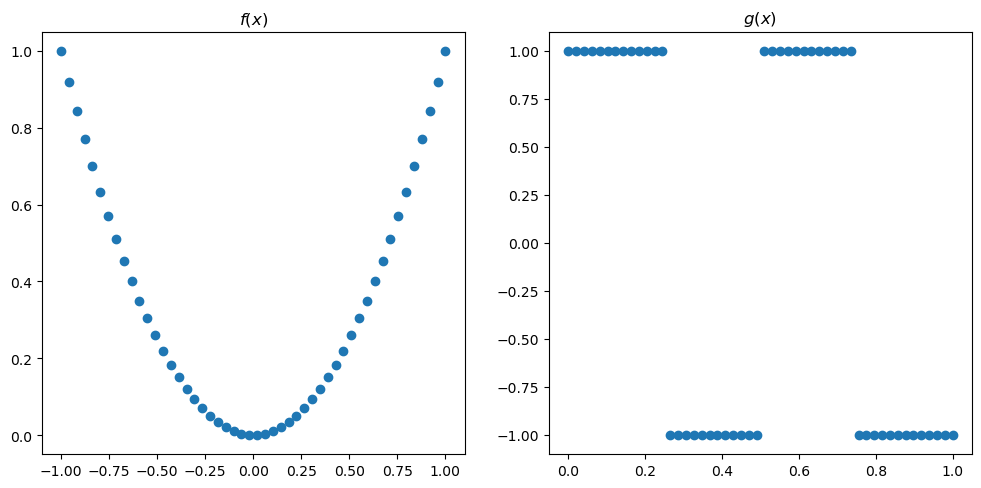

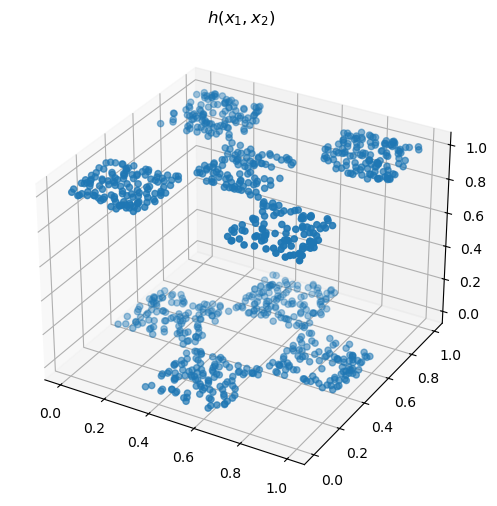

In [4]:
### Plot of first test function
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

x1 = np.linspace(-1, 1, 50)

axs[0].scatter(x1, f(x1, 0))
axs[0].set_title("$f(x)$")
axs[0].set_box_aspect(1)

### Plot of second test function
x2 = np.linspace(0, 1, 50)

axs[1].scatter(x2, g(x2, 0))
axs[1].set_title("$g(x)$")
axs[1].set_box_aspect(1)

plt.show()

### Plot of third test function
fig = plt.figure(figsize=(18, 6))

x3_1 = np.random.uniform(0, 1, 1000)
x3_2 = np.random.uniform(0, 1, 1000)
y3 = h(x3_1, x3_2, 0)

ax3 = fig.add_subplot(111, projection="3d")
ax3.scatter(x3_1, x3_2, y3)
ax3.set_title("$h(x_1, x_2)$")

plt.show()

The functions $ f(x) $, $ g(x) $, and $ h(x_1, x_2) $ are used to test the regression tree. 

# Simple use case


In [5]:
### Data
np.random.seed(10)
X = np.linspace(-1, 1, 50).reshape(-1, 1)
y = f(X.flatten(), 0.2)

### Hyperparameters
max_depth = 3
min_samples_split = 2

### Instantiate regression tree
tree = RegressionTree(max_depth=max_depth, min_samples_split=min_samples_split)

### Fit
tree.fit(X, y)

### Predict
y_pred = tree.predict(X)

### Calculate the training MSE
print(f"Training MSE: {round(MSE(y, y_pred), 3)}")

Training MSE: 0.049


# Model structure
The algorithm is defined in [utils/tree.py](utils/tree.py) following the structure shown below:

## `Node` Class
Represents a single node in the regression tree. No methods are associated with `Node`. 

| Attribute     | Type         | Description                              |
|---------------|--------------|------------------------------------------|
| feature_idx   | int          | Index of the feature used for splitting. |
| x_threshold   | float        | Threshold value for splitting.           |
| left_child    | Node         | Left child node (values < threshold).    |
| right_child   | Node         | Right child node (values ≥ threshold).   |
| node_value    | float        | Predicted value for leaf nodes.          |

## `RegressionTree` Class
Represents a custom implementation of a regression decision tree.

| Attribute        | Type         | Description                                           |
|------------------|--------------|-------------------------------------------------------|
| max_depth        | int or None  | Maximum depth of the tree. If None, depth is unlimited.       |
| min_samples_split| int  | Minimum number of samples required to split a node (default: 2).|
| root             | Node | Root node of the tree.   |


## RegressionTree Class - Method Overview

| Method                                           | Function Type | Description                                                                 |
|--------------------------------------------------|---------------|-----------------------------------------------------------------------------|
| __init__()  | Constructor        | Initializes the regression tree. |
| `fit()`                          | Public        | Trains the tree by recursively splitting the dataset at each node.                        |
| _build_tree() | Helper        | Recursively builds the tree, stopping when certain conditions are met.               |
| _find_best_split()             | Helper        | Determines the best feature for splitting a node.              |
| _split_feature()               | Helper        | Finds the optimal split point for a given feature (1D) using Mean Squared Error (MSE). |
| `predict()`                                | Public        | Predicts target values for new samples based on a trained tree.          |
| _predict()                              | Helper        | Recursively traverses the tree to predict the value of a single sample.      |


# Implementing Cumulative Sums
When constructing decision trees, finding the optimal split at each node requires evaluating different threshold values for each feature. A naive approach would involve recalculating the **Mean Squared Error (MSE)** from scratch for every possible split, which is computationally expensive.

The MSE fora set of values is defined as 
$$
\text{MSE} = \sum (y_{\text{i}} - \bar{y})^2
$$
where:
- $ y_{\text{i}} $ are the individual values,
- $ \bar{y} $ is the mean of the subset.



The split with the smallest mean squared error is selected and the MSE of a given split can be understood as the sum of the left and the right part of the split:

$$
\text{MSE}_{\text{split}} = \text{MSE}_{\text{left}} + \text{MSE}_{\text{right}}
$$

As $ \text{MSE}_{\text{right}}$ can be calculated analogous to $ \text{MSE}_{\text{left}} $, only the latter will be discussed here: 

$$
\text{MSE}_{\text{left}} = \sum (y_{\text{left}} - \bar{y}_{\text{left}})^2
$$

Expanding the squared term gives:

$$
\text{MSE}_{\text{left}} = \sum y_{\text{left}}^2 - 2 \bar{y}_{\text{left}} \sum y_{\text{left}} + \text{count}_{\text{left}} \cdot \bar{y}_{\text{left}}^2
$$

Since the mean is defined as:
$$
\bar{y}_{\text{left}} = \frac{\sum y_{\text{left}}}{\text{count}_{\text{left}}}
$$

Substituting gives:

$$
\text{MSE}_{\text{left}} = \sum y_{\text{left}}^2 - 2 \left( \frac{\sum y_{\text{left}}}{\text{count}_{\text{left}}} \right) \sum y_{\text{left}} + \text{count}_{\text{left}} \left( \frac{\sum y_{\text{left}}}{\text{count}_{\text{left}}} \right)^2
$$


And simplifies to:

$$
\text{MSE}_{\text{left}} = \sum y_{\text{left}}^2 - \frac{(\text{sum}_{\text{left}})^2}{\text{count}_{\text{left}}}
$$

- $\text{MSE}_{\text{right}}$ can be calculated in analogy
- To evaluate every possible split of given vector the cumulative approach as shown above is leaner even if it is not quite as intuitive (at least for a chemist).  

# Performance

### f(x), `n = 50`

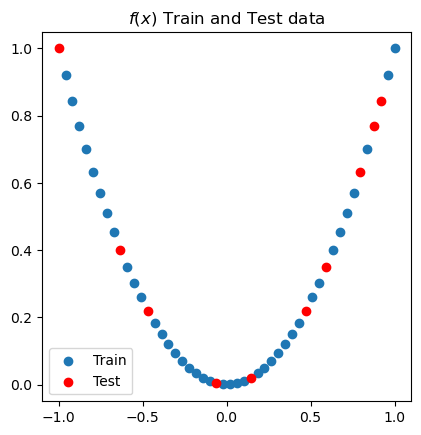

In [6]:
### Data
np.random.seed(0)
X = np.linspace(-1, 1, 50)
y = f(X, 0)

### Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Reshape data
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

### Plot of first test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, color="red", label="Test")
plt.legend()
ax.set_box_aspect(1)
plt.title("$f(x)$ Train and Test data")
plt.show()

depth: 1
depth: 2
depth: 3
depth: 4
depth: None


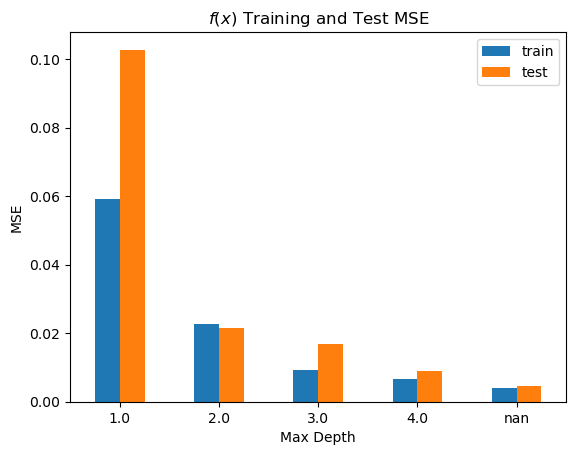

,train,test,n_values
1.000,0.059,0.103,2.000
2.000,0.023,0.021,4.000
3.000,0.009,0.017,7.000
4.000,0.007,0.009,14.000
NaN,0.004,0.005,37.000


In [7]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4, None]
for depth in depths:
    print(f"depth: {depth}")
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (
        MSE(y_train, tree.predict(X_train)),
        MSE(y_test, tree.predict(X_test)),
        pd.Series(tree.predict(X_train)).nunique(),
    )
    models[depth] = tree
df = pd.DataFrame(results, index=["train", "test", "n_values"]).T
df[
    [
        "train",
        "test",
    ]
].plot(kind="bar")
plt.ylabel("MSE")
plt.xlabel("Max Depth")
plt.xticks(rotation=0)
plt.title("$f(x)$ Training and Test MSE")
plt.show()
df

### g(x), `n = 50`

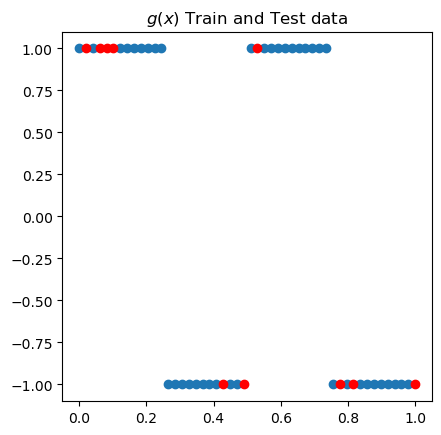

In [8]:
### Data
np.random.seed(0)
X = np.linspace(0, 1, 50)
y = g(X, 0)

### Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

### Reshape data
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)


# Plot of second test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color="red")
ax.set_box_aspect(1)
plt.title("$g(x)$ Train and Test data")
plt.show()

depth: 1
depth: 2
depth: 3
depth: 4
depth: None


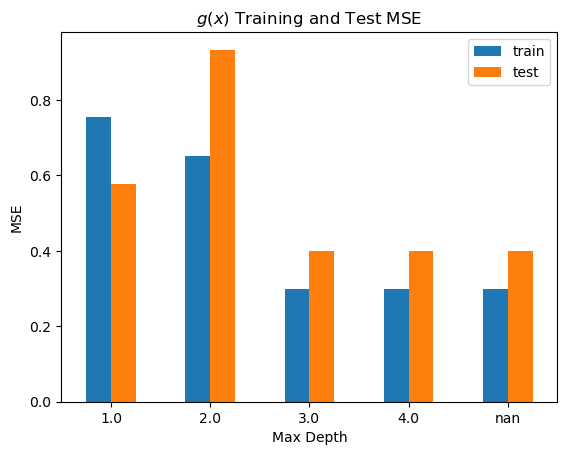

,train,test,values
1.000,0.756,0.578,"[0.3333333333333333, -1.0]"
2.000,0.651,0.933,"[-0.05263157894736842, -1.0, 1.0]"
3.000,0.300,0.400,"[-1.0, 1.0]"
4.000,0.300,0.400,"[-1.0, 1.0]"
NaN,0.300,0.400,"[-1.0, 1.0]"


In [9]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4, None]
for depth in depths:
    print(f"depth: {depth}")
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (
        MSE(y_train, tree.predict(X_train)),
        MSE(y_test, tree.predict(X_test)),
        pd.Series(tree.predict(X_train)).unique(),
    )
    models[depth] = tree


df = pd.DataFrame(results, index=["train", "test", "values"]).T
df[
    [
        "train",
        "test",
    ]
].plot(kind="bar")
plt.ylabel("MSE")
plt.xlabel("Max Depth")
plt.xticks(rotation=0)
plt.title("$g(x)$ Training and Test MSE")
plt.show()
df

### h(x), n = `10_000`

In [10]:
### Seeding
np.random.seed(0)

### Features
x0 = np.random.uniform(0, 1, 1000)
x1 = np.random.uniform(0, 1, 1000)
X = np.column_stack((x0, x1))

### Target
y = h(x0, x1, 0)

### Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

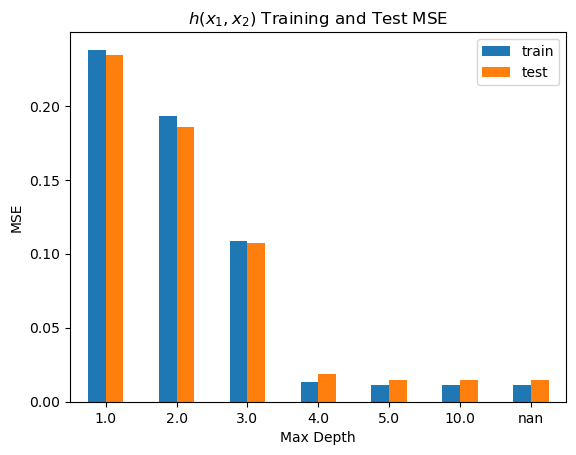

,train,test,values
1.000,0.238,0.234,"[0.4712430426716141, 0.6896551724137931]"
2.000,0.193,0.185,"[0.6802973977695167, 0.5207100591715976, 0.262..."
3.000,0.109,0.107,"[0.48502994011976047, 0.0, 0.42771084337349397..."
4.000,0.013,0.019,"[0.0, 0.9594594594594594, 1.0]"
5.000,0.011,0.015,"[0.0, 1.0]"
10.000,0.011,0.015,"[0.0, 1.0]"
NaN,0.011,0.015,"[0.0, 1.0]"


In [11]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4, 5, 10, None]
for depth in depths:
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (
        MSE(y_train, tree.predict(X_train)),
        MSE(y_test, tree.predict(X_test)),
        pd.Series(tree.predict(X_train)).unique(),
    )
    models[depth] = tree

### Plot MSEs
df = pd.DataFrame(results, index=["train", "test", "values"]).T
df[
    [
        "train",
        "test",
    ]
].plot(kind="bar")
plt.ylabel("MSE")
plt.xlabel("Max Depth")
plt.xticks(rotation=0)
plt.title("$h(x_1, x_2)$ Training and Test MSE")
plt.show()
df

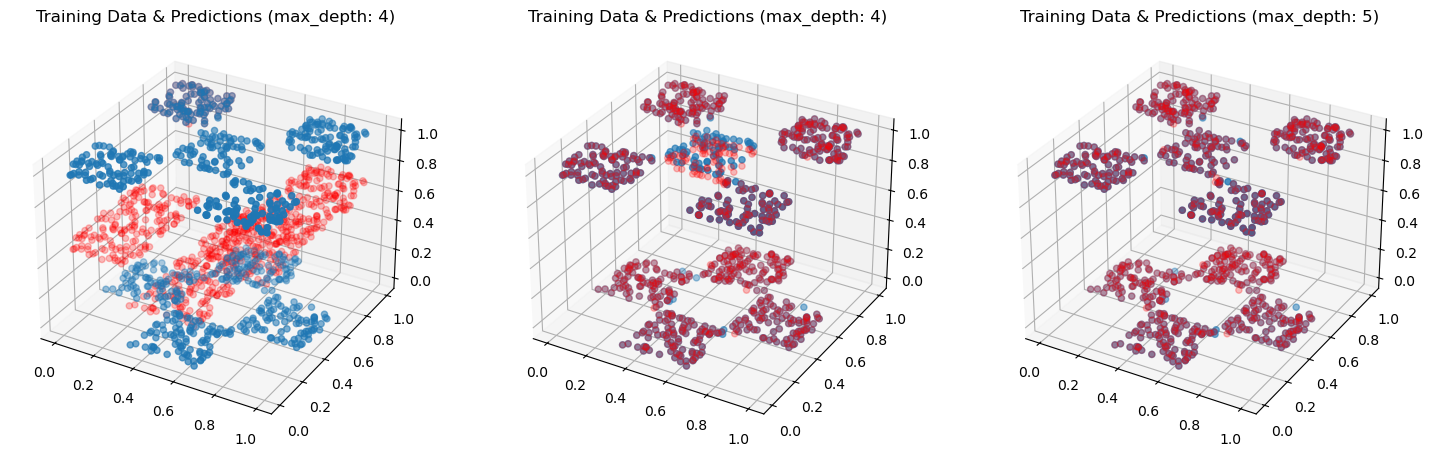

max_depth: 4 values


In [12]:
### Chose models to plot
left_depth = 2
middle_depth = 4
right_depth = 5
alpha = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": "3d"})

# First plot
axs[0].scatter(X_train[:, 0], X_train[:, 1], y_train)
axs[0].scatter(
    X_train[:, 0],
    X_train[:, 1],
    models[left_depth].predict(X_train),
    color="red",
    alpha=alpha,
)
axs[0].set_title(f"Training Data & Predictions (max_depth: {middle_depth})")

# Second plot
axs[1].scatter(X_train[:, 0], X_train[:, 1], y_train)
axs[1].scatter(
    X_train[:, 0],
    X_train[:, 1],
    models[middle_depth].predict(X_train),
    color="red",
    alpha=alpha,
)
axs[1].set_title(f"Training Data & Predictions (max_depth: {middle_depth})")

# Third plot
axs[2].scatter(X_train[:, 0], X_train[:, 1], y_train)
axs[2].scatter(
    X_train[:, 0],
    X_train[:, 1],
    models[right_depth].predict(X_train),
    color="red",
    alpha=alpha,
)
axs[2].set_title(f"Training Data & Predictions (max_depth: {right_depth})")

plt.show()

print(f"max_depth: {middle_depth} values")

### Checking for features dimensionality

In [13]:
### Check if the decision tree can handle features of different dimensions
dimensions = [1, 2, 3, 4, 5, 10, 100, 1000]

for dim in dimensions:
    print(f"Dimension: {dim}")
    X, y = make_regression(n_samples=100, n_features=dim, noise=0.1)
    tree = RegressionTree(max_depth=10, min_samples_split=2)
    try:
        result = tree.fit(X, y)
    except Exception as e:
        # Handle the error
        print(f"Error: {e}")
        result = None

Dimension: 1
Dimension: 2
Dimension: 3
Dimension: 4
Dimension: 5
Dimension: 10
Dimension: 100
Dimension: 1000


# Conclusion
A decision tree for regression was successfully implemented as class and tested against various artificial data sets. 